<a href="https://colab.research.google.com/github/amaziarczyk/Konwolucyjne-sieci-neuronowe/blob/main/Patologia_roslin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Zadanie: WYZWANIE Klasyfikacja obrazów (patologii roślin)

Celem zadania jest przedstawienie sposobu trenowania sieci CNN oraz analiza otrzymanych wyników

 zbiór danych https://www.kaggle.com/c/plant-pathology-2020-fgvc7/data




In [ ]:
!pip install tensorflow

## Rozwiązanie

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import plotly.graph_objects as go
import tensorflow as tf
import sklearn
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import VGG19

np.set_printoptions(precision=6, suppress=True)
print(tf.__version__)

2.5.0


In [ ]:
dane=pd.read_csv('/content/drive/MyDrive/Asseco/plant-pathology-2020-fgvc7/train.csv')
test=pd.read_csv('/content/drive/MyDrive/Asseco/plant-pathology-2020-fgvc7/test.csv')
sample_submission=pd.read_csv('/content/drive/MyDrive/Asseco/plant-pathology-2020-fgvc7/sample_submission.csv')

In [ ]:
dane.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [ ]:
#wyczyszczenie katalogo roboczego przy kolejnch próbach
!rm -rf ./zdjecia

#utworzenie folderu
wszystkie_zdjecia='./zdjecia'
if not os.path.exists(wszystkie_zdjecia):
  os.mkdir(wszystkie_zdjecia)



In [ ]:
#pobranie zbioru zdjęc
zdjecia=('/content/drive/MyDrive/Asseco/plant-pathology-2020-fgvc7/images')

#lista z elementami zbioru images
images_list= list(os.listdir(zdjecia))

print(f'W zbiorze jest: {len(images_list)} zdjęć')

W zbiorze jest: 3642 zdjęć


(-0.5, 2047.5, 1364.5, -0.5)

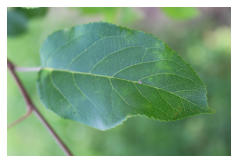

In [ ]:
#podgląd zdjęcia
#@title Wybierz indeks zdjęcia:

#budowa slidera
idx = 679 #@param {type:'slider', min:0, max:3642}
names_mapping = dict(enumerate(images_list))
img_path = os.path.join(zdjecia, names_mapping[idx])

#wyświetlenie zdjęcia
img = image.load_img(img_path)

plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis(False)

In [ ]:
#utworzenie katalogów
#nowy  nadrzędny katalog
data_dir = './images'

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

#nowe katalogi 
train_dir = os.path.join(data_dir, 'train')    # katalog zbioru treningowego
valid_dir = os.path.join(data_dir, 'valid')    # katalog zbioru walidacyjnego
test_dir = os.path.join(data_dir, 'test')      # katalog zbioru testowego

#nowe podkatalogi
train_healthy_dir = os.path.join(train_dir, 'healthy')
train_multiple_diseases_dir = os.path.join(train_dir, 'multiple_diseases')
train_rust_dir = os.path.join(train_dir, 'rust')
train_scab_dir = os.path.join(train_dir, 'scab')

valid_healthy_dir = os.path.join(valid_dir, 'healthy')
valid_multiple_diseases_dir = os.path.join(valid_dir, 'multiple_diseases')
valid_rust_dir = os.path.join(valid_dir, 'rust')
valid_scab_dir = os.path.join(valid_dir, 'scab')

test_healthy_dir = os.path.join(test_dir, 'healthy')
test_multiple_diseases_dir = os.path.join(test_dir, 'multiple_diseases')
test_rust_dir = os.path.join(test_dir, 'rust')
test_scab_dir = os.path.join(test_dir, 'scab')

#pętla do tworzenia katalogów
for directory in (train_dir, valid_dir, test_dir):
    if not os.path.exists(directory):
        os.mkdir(directory)

#pętla do tworzenia podkatalogów
dirs = [train_healthy_dir, train_multiple_diseases_dir, train_rust_dir, train_scab_dir, valid_healthy_dir, valid_multiple_diseases_dir, valid_rust_dir, valid_scab_dir, test_healthy_dir, test_multiple_diseases_dir, test_rust_dir, test_scab_dir]

for dir in dirs:
    if not os.path.exists(dir):
        os.mkdir(dir)

### Generowanie zbiorów

In [ ]:
dane.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [ ]:
#generowanie zbiorów
healthy=dane[dane['healthy']==1]
multiple_diseases=dane[dane['multiple_diseases']==1]
rust=dane[dane['rust']==1]
scab=dane[dane['scab']==1]

In [ ]:
#size train
size_train_healthy=int(np.floor(0.7*len(healthy)))
size_train_multiple_diseases=int(np.floor(0.7*len(multiple_diseases)))
size_train_rust=int(np.floor(0.7*len(rust)))
size_train_scab=int(np.floor(0.7*len(scab)))

#size test
size_test_healthy=int(np.floor(0.1*len(healthy)))
size_test_multiple_diseases=int(np.floor(0.1*len(multiple_diseases)))
size_test_rust=int(np.floor(0.1*len(rust)))
size_test_scab=int(np.floor(0.1*len(scab)))

#size valid
size_valid_healthy=int(np.floor(0.2*len(healthy)))
size_valid_multiple_diseases=int(np.floor(0.2*len(multiple_diseases)))
size_valid_rust=int(np.floor(0.2*len(rust)))
size_valid_scab=int(np.floor(0.2*len(scab)))


#rozmiar zbioru
#health
train_idx_h = size_train_healthy
valid_idx_h = size_train_healthy + size_valid_healthy
test_idx_h = size_train_healthy + size_valid_healthy + size_test_healthy

#multiple_diseases
train_idx_m = size_train_multiple_diseases
valid_idx_m = size_train_multiple_diseases + size_valid_multiple_diseases
test_idx_m = size_train_multiple_diseases + size_valid_multiple_diseases + size_test_multiple_diseases

#rust
train_idx_r = size_train_rust
valid_idx_r = size_train_rust + size_valid_rust
test_idx_r = size_train_rust + size_valid_rust + size_test_rust

#scab
train_idx_s = size_train_scab
valid_idx_s = size_train_scab + size_valid_scab
test_idx_s = size_train_scab + size_valid_scab + size_test_scab

In [ ]:
train_size= size_train_healthy +size_train_multiple_diseases+size_train_rust+size_train_scab
valid_size= size_valid_healthy +size_valid_multiple_diseases+size_valid_rust+size_valid_scab

In [ ]:
#listy
lista_healthy = healthy['image_id'].apply(lambda x: x + ".jpg").to_list()
lista_multiple_diseases = multiple_diseases['image_id'].apply(lambda x: x + ".jpg").to_list()
lista_rust = rust['image_id'].apply(lambda x: x + ".jpg").to_list()
lista_scab = scab['image_id'].apply(lambda x: x + ".jpg").to_list()

In [ ]:
#uzupełnienie katalogów train, test, valid
#healthy
for i, fname in enumerate(lista_healthy):
    if i <= train_idx_h:
        src = os.path.join(zdjecia, fname)
        dst = os.path.join(train_healthy_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx_h < i <= valid_idx_h:
        src = os.path.join(zdjecia, fname)
        dst = os.path.join(valid_healthy_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx_h < i < test_idx_h:
        src = os.path.join(zdjecia, fname)
        dst = os.path.join(test_healthy_dir, fname)
        shutil.copyfile(src, dst)

print('Healthy - zbiór treningowy', len(os.listdir(train_healthy_dir)))
print('Healthy - zbiór walidacyjny', len(os.listdir(valid_healthy_dir)))
print('Healthy - zbiór testowy', len(os.listdir(test_healthy_dir)))

#multiple_diseases
for i, fname in enumerate(lista_multiple_diseases):
    if i <= train_idx_m:
        src = os.path.join(zdjecia, fname)
        dst = os.path.join(train_multiple_diseases_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx_m < i <= valid_idx_m:
        src = os.path.join(zdjecia, fname)
        dst = os.path.join(valid_multiple_diseases_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx_m < i < test_idx_m:
        src = os.path.join(zdjecia, fname)
        dst = os.path.join(test_multiple_diseases_dir, fname)
        shutil.copyfile(src, dst)

print('Multiple_diseases - zbiór treningowy', len(os.listdir(train_multiple_diseases_dir)))
print('Multiple_diseases - zbiór walidacyjny', len(os.listdir(valid_multiple_diseases_dir)))
print('Multiple_diseases - zbiór testowy', len(os.listdir(test_multiple_diseases_dir)))

#rust
for i, fname in enumerate(lista_rust):
    if i <= train_idx_r:
        src = os.path.join(zdjecia, fname)
        dst = os.path.join(train_rust_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx_r < i <= valid_idx_r:
        src = os.path.join(zdjecia, fname)
        dst = os.path.join(valid_rust_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx_r < i < test_idx_r:
        src = os.path.join(zdjecia, fname)
        dst = os.path.join(test_rust_dir, fname)
        shutil.copyfile(src, dst)

print('Rust - zbiór treningowy', len(os.listdir(train_rust_dir)))
print('Rust - zbiór walidacyjny', len(os.listdir(valid_rust_dir)))
print('Rust - zbiór testowy', len(os.listdir(test_rust_dir)))

#scab
for i, fname in enumerate(lista_scab):
    if i <= train_idx_s:
        src = os.path.join(zdjecia, fname)
        dst = os.path.join(train_scab_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx_s < i <= valid_idx_s:
        src = os.path.join(zdjecia, fname)
        dst = os.path.join(valid_scab_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx_s < i < test_idx_s:
        src = os.path.join(zdjecia, fname)
        dst = os.path.join(test_scab_dir, fname)
        shutil.copyfile(src, dst)

print('Scab - zbiór treningowy', len(os.listdir(train_scab_dir)))
print('Scab - zbiór walidacyjny', len(os.listdir(valid_scab_dir)))
print('Scab - zbiór testowy', len(os.listdir(test_scab_dir)))

Healthy - zbiór treningowy 362
Healthy - zbiór walidacyjny 103
Healthy - zbiór testowy 50
Multiple_diseases - zbiór treningowy 64
Multiple_diseases - zbiór walidacyjny 18
Multiple_diseases - zbiór testowy 8
Rust - zbiór treningowy 436
Rust - zbiór walidacyjny 124
Rust - zbiór testowy 61
Scab - zbiór treningowy 415
Scab - zbiór walidacyjny 118
Scab - zbiór testowy 58


### Model I

In [ ]:
model_1=Sequential()
model_1.add(layers.Conv2D(filters=32,kernel_size=(3,3), activation='relu', input_shape=(150,150,3)))
model_1.add(layers.MaxPool2D(pool_size=(2,2)))
model_1.add(layers.Conv2D(filters=64,kernel_size=(3,3), activation='relu', input_shape=(150,150,3)))
model_1.add(layers.MaxPool2D(pool_size=(2,2)))
model_1.add(layers.Conv2D(filters=128,kernel_size=(3,3), activation='relu', input_shape=(150,150,3)))
model_1.add(layers.MaxPool2D(pool_size=(2,2)))
model_1.add(layers.Conv2D(filters=128,kernel_size=(3,3), activation='relu', input_shape=(150,150,3)))
model_1.add(layers.MaxPool2D(pool_size=(2,2)))
model_1.add(layers.Flatten())
model_1.add(layers.Dense(units=256, activation='relu'))
model_1.add(layers.Dense(units=4, activation='softmax'))
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)      

W modelu do trenwania jest 1,847,748 parametrów. Pierwsza warstwa po konwolucji to 148 na 148 i 32 filtry. Max pooling zmniejsza rozmiar o połowę, a następna warstwa conv2d_5 zabiera 2 z wymiaru (72 na 72 i 32 filtry). Warstwa flatten rozpłaszczy dane na 6272elementy. Ostatnia warstwa Danse zwróci 4 elementy.

In [ ]:
model_1.compile(optimizer=optimizers.RMSprop(lr=1e-5),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
#przygotowanie danych do modelu na wartości małe, tworzymy obiekty dla zbioru treningowego i walidacyjnego

train_datagen_1=ImageDataGenerator(rescale=1./255.)
valid_datagen_1=ImageDataGenerator(rescale=1./255)


#generatory treningowy i walidacyjny
train_generator_1=train_datagen_1.flow_from_directory(directory=train_dir,
                                  target_size=(150,150),
                                  batch_size=32,
                                  class_mode='categorical')

valid_generator_1=train_datagen_1.flow_from_directory(directory=valid_dir,
                                  target_size=(150,150),
                                  batch_size=32,
                                  class_mode='categorical')

Found 1277 images belonging to 4 classes.
Found 363 images belonging to 4 classes.


Dopasowanie modelu

In [ ]:
history_1 = model_1.fit_generator(generator=train_generator_1,
                             steps_per_epoch=20,
                             epochs=30,   
                             validation_data=valid_generator_1,
                             validation_steps=10)

#zapis
model_1.save('plant_patolpgy_1.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/30
20/20 [==============================] - 32s 2s/step - loss: 1.3299 - accuracy: 0.2859 - val_loss: 1.2847 - val_accuracy: 0.3406
Epoch 2/30
20/20 [==============================] - 30s 2s/step - loss: 1.2674 - accuracy: 0.3656 - val_loss: 1.2542 - val_accuracy: 0.3469
Epoch 3/30
20/20 [==============================] - 30s 2s/step - loss: 1.2452 - accuracy: 0.3422 - val_loss: 1.2391 - val_accuracy: 0.3531
Epoch 4/30
20/20 [==============================] - 30s 2s/step - loss: 1.2452 - accuracy: 0.3485 - val_loss: 1.2362 - val_accuracy: 0.3562
Epoch 5/30
20/20 [==============================] - 29s 1s/step - loss: 1.2396 - accuracy: 0.3422 - val_loss: 1.2236 - val_accuracy: 0.3281
Epoch 6/30
20/20 [==============================] - 29s 1s/step - loss: 1.2385 - accuracy: 0.4000 - val_loss: 1.2149 - val_accuracy: 0.3531
Epoch 7/30
20/20 [==============================] - 29s 1s/step - loss: 1.2439 - accuracy: 0.3391 - val_loss: 1.2333 - val_accuracy: 0.4031
Epoch 8/30
20/20 [==

In [ ]:
#wykres dokładności i straty
def plot_hist(history_1):
    hist_1 = pd.DataFrame(history_1.history)
    hist_1['epoch'] = history_1.epoch

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist_1['epoch'], y=hist_1['accuracy'], name='accuracy', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist_1['epoch'], y=hist_1['val_accuracy'], name='val_accuracy', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Model 1: Accuracy vs. Val Accuracy', xaxis_title='Epoki', yaxis_title='Accuracy', yaxis_type='log')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist_1['epoch'], y=hist_1['loss'], name='loss', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist_1['epoch'], y=hist_1['val_loss'], name='val_loss', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Model 1: Loss vs. Val Loss', xaxis_title='Epoki', yaxis_title='Loss', yaxis_type='log')
    fig.show()

plot_hist(history_1)

Model jest bardo niedokładny. Zauważalny jest duży szum w danych. Dokładność na poziomie 48% na zbiorze treningowym po 30 epokach. Zauważalne są odchylenia między dokładnością na zbiorze treningowym i walidacyjnym, model nie jest stabliny w czasie. Strata na zbiorze treningowym i walidacyjnym uległa zmniejszeniu jednakże posiada spore odchylenia. Model nie jest stabilny w czasie. Należy poprawić model dlatego przechodzę do augumentacji danych.



### Model II z augumentacją danych

In [ ]:
#tworzę nowy generator z przekształceniami zdjęć
train_datagen = ImageDataGenerator(
    rotation_range=40,     # zakres kąta o który losowo zostanie wykonany obrót obrazów
    rescale=1./255.,
    width_shift_range=0.2,  # pionowe przekształcenia obrazu
    height_shift_range=0.2, # poziome przekształcenia obrazu
    shear_range=0.2,        # zakres losowego przycianania obrazu
    zoom_range=0.2,         # zakres losowego przybliżania obrazu
    horizontal_flip=True,   # losowe odbicie połowy obrazu w płaszczyźnie poziomej
    fill_mode='nearest',    # strategia wypełniania nowo utworzonych pikseli, któe mogą powstać w wyniku przekształceń   
)
# skalujemy wszystkie obrazy o współczynnik 1/255
valid_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='categorical')

Found 1277 images belonging to 4 classes.
Found 363 images belonging to 4 classes.


Wyświetlenie przykładów augumentacji

In [ ]:
#przygotowanie do wyswietlenia
def display_augmented_images(directory, idx):
    """
    Funkcja zwraca wykres przykładowych obrazów uzyskanych za pomocą techniki
    augmentacji danych.
    """
    fnames = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    img_path = fnames[idx]
    img = image.load_img(img_path, target_size=(150, 150))

    x = image.img_to_array(img)
    x = x.reshape((1, ) + x.shape)

    i = 1
    plt.figure(figsize=(16, 8))
    for batch in train_datagen.flow(x, batch_size=1):
        plt.subplot(3, 4, i)
        plt.grid(False)
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        i += 1
        if i % 13 == 0:
            break

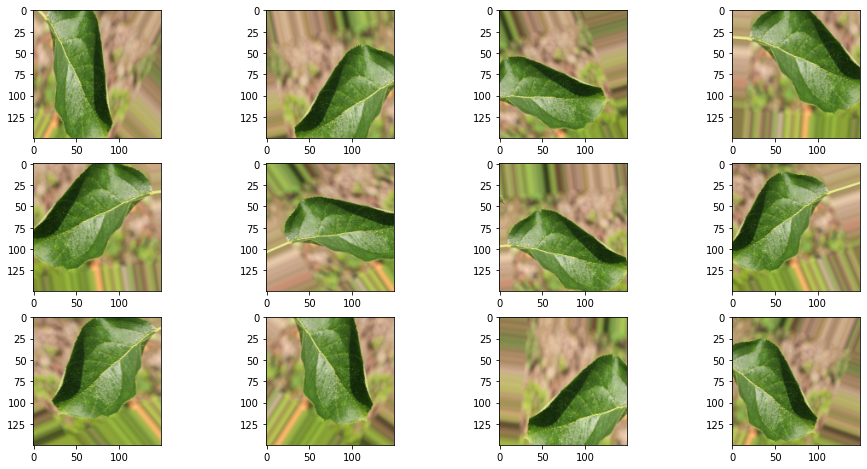

In [ ]:
#@title Zbiór treningowy healthy:
idx = 89 #@param {type:'slider', min:0, max:362}
display_augmented_images(train_healthy_dir, idx)

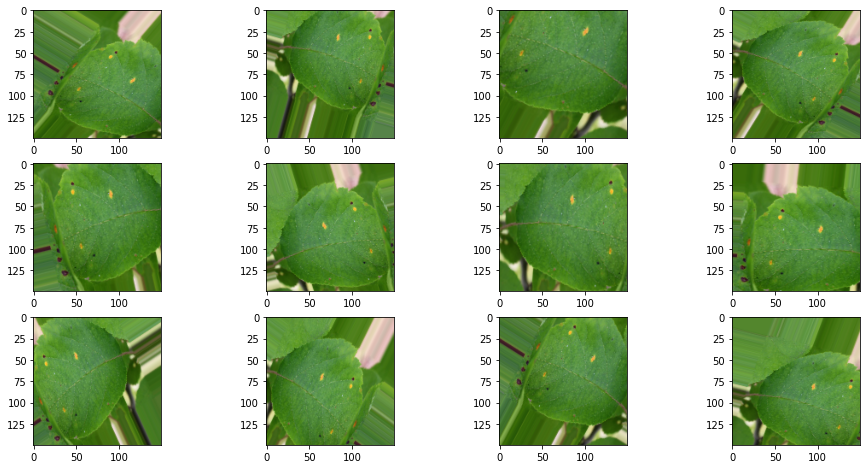

In [ ]:
#@title Zbiór treningowy Multiple_diseases:
idx = 35 #@param {type:'slider', min:0, max:64}
display_augmented_images(train_multiple_diseases_dir, idx)

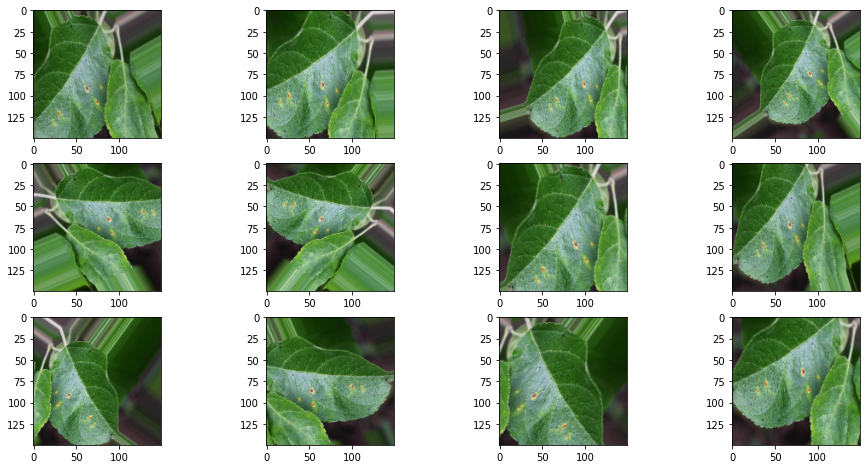

In [ ]:
#@title Zbiór treningowy rust:
idx = 222 #@param {type:'slider', min:0, max:436}
display_augmented_images(train_rust_dir, idx)

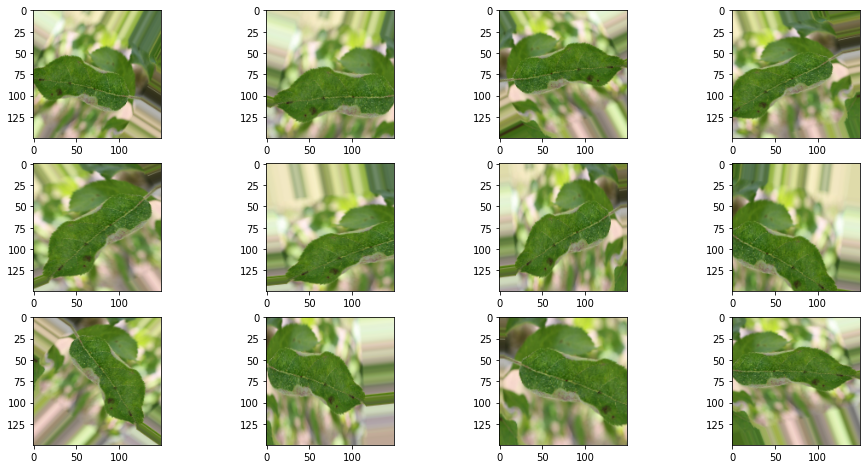

In [ ]:
#@title Zbiór treningowy scab:
idx = 60 #@param {type:'slider', min:0, max:415}
display_augmented_images(train_scab_dir, idx)

### Model VGG19

In [ ]:
batch_size = 32
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size

In [ ]:
conv_base = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.trainable = True

def print_layers(model):
    for layer in model.layers:
        print(f'layer_name: {layer.name:13} trainable: {layer.trainable}')

print_layers(conv_base)

80142336/80134624 [==============================] - 1s 0us/step
layer_name: input_1       trainable: True
layer_name: block1_conv1  trainable: True
layer_name: block1_conv2  trainable: True
layer_name: block1_pool   trainable: True
layer_name: block2_conv1  trainable: True
layer_name: block2_conv2  trainable: True
layer_name: block2_pool   trainable: True
layer_name: block3_conv1  trainable: True
layer_name: block3_conv2  trainable: True
layer_name: block3_conv3  trainable: True
layer_name: block3_conv4  trainable: True
layer_name: block3_pool   trainable: True
layer_name: block4_conv1  trainable: True
layer_name: block4_conv2  trainable: True
layer_name: block4_conv3  trainable: True
layer_name: block4_conv4  trainable: True
layer_name: block4_pool   trainable: True
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_conv4  trainable: True
layer_name: block5_pool   trainable: True


In [ ]:
#odmrożenie kilku oststnich warstw
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print_layers(conv_base)

layer_name: input_1       trainable: False
layer_name: block1_conv1  trainable: False
layer_name: block1_conv2  trainable: False
layer_name: block1_pool   trainable: False
layer_name: block2_conv1  trainable: False
layer_name: block2_conv2  trainable: False
layer_name: block2_pool   trainable: False
layer_name: block3_conv1  trainable: False
layer_name: block3_conv2  trainable: False
layer_name: block3_conv3  trainable: False
layer_name: block3_conv4  trainable: False
layer_name: block3_pool   trainable: False
layer_name: block4_conv1  trainable: False
layer_name: block4_conv2  trainable: False
layer_name: block4_conv3  trainable: False
layer_name: block4_conv4  trainable: False
layer_name: block4_pool   trainable: False
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_conv4  trainable: True
layer_name: block5_pool   trainable: True


In [ ]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=4, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 1028      
Total params: 22,122,820
Trainable params: 11,537,668
Non-trainable params: 10,585,152
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=50,   
                             validation_data=valid_generator,
                             validation_steps=validation_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/50
39/39 [==============================] - 54s 1s/step - loss: 1.0688 - accuracy: 0.5317 - val_loss: 1.0345 - val_accuracy: 0.6023
Epoch 2/50
39/39 [==============================] - 54s 1s/step - loss: 0.9986 - accuracy: 0.5711 - val_loss: 0.9463 - val_accuracy: 0.6449
Epoch 3/50
39/39 [==============================] - 54s 1s/step - loss: 0.9635 - accuracy: 0.5984 - val_loss: 0.9525 - val_accuracy: 0.6506
Epoch 4/50
39/39 [==============================] - 54s 1s/step - loss: 0.8919 - accuracy: 0.6442 - val_loss: 0.8982 - val_accuracy: 0.6648
Epoch 5/50
39/39 [==============================] - 55s 1s/step - loss: 0.8731 - accuracy: 0.6618 - val_loss: 0.8885 - val_accuracy: 0.6790
Epoch 6/50
39/39 [==============================] - 54s 1s/step - loss: 0.8558 - accuracy: 0.6562 - val_loss: 1.0481 - val_accuracy: 0.5966
Epoch 7/50
39/39 [==============================] - 55s 1s/step - loss: 0.8381 - accuracy: 0.6699 - val_loss: 0.8524 - val_accuracy: 0.6989
Epoch 8/50
39/39 [==

In [ ]:
#zapis modelu
model_1.save('plant_patolpgy_vgg19.h5')

In [ ]:
#wizualizacja dokładności i straty modelu
def plot_hist(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='accuracy', mode='markers+lines',marker_color="lightskyblue"))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='val_accuracy', mode='markers+lines', marker_color='rgba(255, 182, 193, .9)'))
    fig.update_layout(width=1000, height=500, title='Accuracy vs. Val Accuracy', xaxis_title='Epoki', yaxis_title='Accuracy', yaxis_type='log')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='loss', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='val_loss', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Loss vs. Val Loss', xaxis_title='Epoki', yaxis_title='Loss', yaxis_type='log')
    fig.show()

plot_hist(history)

- ***Wykres dokładności "Accuracy vs. Val Accuracy":***

Odchylenia na zbiorze treningowym i walidacyjnym zostały  zmniejszone, model jest stabliny w czasie. 

- ***Wykres straty "Loss vs. Val Loss":***

Strata na zbiorze trenngowym i walidacyjnym się zmniejsza.Zjawisko pozytywne. Jednak strata na zbiorze walidacyjnym jest większa niż na treningowym.

### Ocena modelu - zbiór testowy

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

y_prob = model.predict_generator(test_generator, test_generator.samples)
y_pred=np.argmax(y_prob, axis=1)
y_pred

Found 177 images belonging to 4 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



array([2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 3, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2,
       2, 2, 0, 3, 2, 2, 0, 2, 0, 2, 2, 3, 2, 1, 3, 0, 2, 3, 3, 0, 3, 2,
       3, 3, 2, 0, 2, 0, 2, 3, 0, 3, 2, 3, 2, 3, 3, 3, 0, 0, 3, 2, 3, 2,
       2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 0, 0, 3, 0, 2, 3, 3, 3, 3,
       2])

In [ ]:
#sprawdzam predykcje i dodaje zmienną "class" jako przewidywana klasa
predictions  = pd.DataFrame({'class': y_pred})
predictions

,class
0,2
1,0
2,0
3,0
4,0
...,...
172,3
173,3
174,3
175,3


In [ ]:
#sprawdzam jakie klasy były w generatorze i oznaczam jako zmienne  y_true
y_true = test_generator.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3], dtype=int32)

In [ ]:
#sprawdzam predykcje z modelu VGG19
y_pred = predictions['class'].values
y_pred

array([2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 3, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2,
       2, 2, 0, 3, 2, 2, 0, 2, 0, 2, 2, 3, 2, 1, 3, 0, 2, 3, 3, 0, 3, 2,
       3, 3, 2, 0, 2, 0, 2, 3, 0, 3, 2, 3, 2, 3, 3, 3, 0, 0, 3, 2, 3, 2,
       2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 0, 0, 3, 0, 2, 3, 3, 3, 3,
       2])

In [ ]:
#sprawdzam oznaczenia klas
test_generator.class_indices

{'healthy': 0, 'multiple_diseases': 1, 'rust': 2, 'scab': 3}

In [ ]:
classes = list(test_generator.class_indices.keys())
classes

['healthy', 'multiple_diseases', 'rust', 'scab']

In [ ]:
#buduję macierz konfuzji w celu sprawdzenia pomyłek
cm = confusion_matrix(y_true, y_pred)

def plot_confusion_matrix(cm):
    # Mulitclass classification, 3 classes
    cm = cm[::-1]
    cm = pd.DataFrame(cm, columns=classes, index=classes[::-1])

    fig = ff.create_annotated_heatmap(z=cm.values, x=list(cm.columns), y=list(cm.index), colorscale='ice', showscale=True, reversescale=True)
    fig.update_layout(width=500, height=500, font_size=16)
    fig.show()

import plotly.figure_factory as ff
plot_confusion_matrix(cm)

In [ ]:
#raport klasyfikacji
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

                   precision    recall  f1-score   support

          healthy       0.68      0.84      0.75        50
multiple_diseases       0.50      0.12      0.20         8
             rust       0.63      0.85      0.72        61
             scab       0.93      0.48      0.64        58

         accuracy                           0.69       177
        macro avg       0.68      0.58      0.58       177
     weighted avg       0.74      0.69      0.68       177



Precyzja czyli prawdopodobieństwo otrzymania poprawnej pozytywnej klasyfikacji, pod warunkiem, że otrzymaliśmy przypadek pozytywny.Największa precyzja 0,93 osiągnęła kategoria "scub". Oznacza to, że w 93% model się nie pomylił (obserwacje prawdziwe określił jako prawdziwe). Niestety rozkład elementów w klasach jest nierównomierny zatem interpretacja tylko dokładności może być niewystarczająca. 

Recall to stosunek poprawnie rozpoznanych elementów do wszystkich, które powinien rozpoznać. W tym przypadku model najlepier poradził sobie z "rust" 85% i "healthy" 84%

### Błędy predykcji

In [ ]:
#DataFrame z błędami predykcji
errors = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}, index=test_generator.filenames)
errors['is_incorrect'] = (errors['y_true'] != errors['y_pred']) * 1
errors.head()

,y_true,y_pred,is_incorrect
healthy/Train_1635.jpg,0,2,1
healthy/Train_1646.jpg,0,0,0
healthy/Train_1653.jpg,0,0,0
healthy/Train_1654.jpg,0,0,0
healthy/Train_1656.jpg,0,0,0


In [ ]:
#indeksy zdjęć błędnie klasyfikowanych
errors[errors['is_incorrect'] == 1].index

Index(['healthy/Train_1635.jpg', 'healthy/Train_1667.jpg',
       'healthy/Train_1682.jpg', 'healthy/Train_1691.jpg',
       'healthy/Train_1693.jpg', 'healthy/Train_1760.jpg',
       'healthy/Train_1774.jpg', 'healthy/Train_1799.jpg',
       'multiple_diseases/Train_1641.jpg', 'multiple_diseases/Train_1648.jpg',
       'multiple_diseases/Train_1662.jpg', 'multiple_diseases/Train_1664.jpg',
       'multiple_diseases/Train_1779.jpg', 'multiple_diseases/Train_1780.jpg',
       'multiple_diseases/Train_1784.jpg', 'rust/Train_1686.jpg',
       'rust/Train_1695.jpg', 'rust/Train_1753.jpg', 'rust/Train_1785.jpg',
       'rust/Train_1788.jpg', 'rust/Train_1796.jpg', 'rust/Train_1797.jpg',
       'rust/Train_1805.jpg', 'rust/Train_1813.jpg', 'scab/Train_1638.jpg',
       'scab/Train_1639.jpg', 'scab/Train_1645.jpg', 'scab/Train_1647.jpg',
       'scab/Train_1652.jpg', 'scab/Train_1658.jpg', 'scab/Train_1673.jpg',
       'scab/Train_1685.jpg', 'scab/Train_1692.jpg', 'scab/Train_1696.jpg',
     

(-0.5, 2047.5, 1364.5, -0.5)

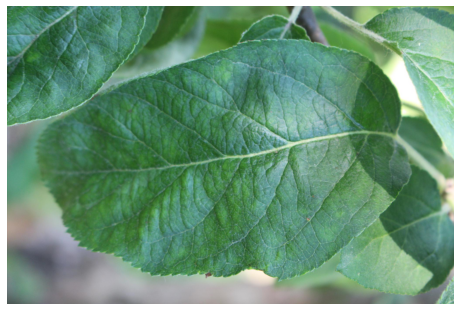

In [ ]:
#źle określone healthy
img_path = os.path.join(test_healthy_dir, 'Train_1799.jpg')

img = image.load_img(img_path)

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis(False)

(-0.5, 2047.5, 1364.5, -0.5)

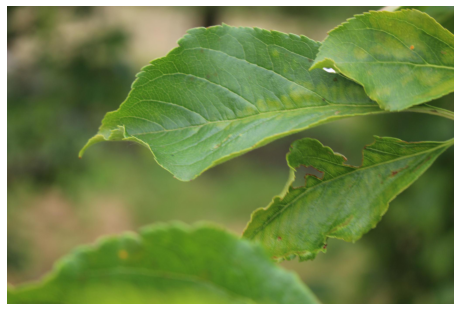

In [ ]:
#źle określone multiple_diseases
img_path = os.path.join(test_multiple_diseases_dir, 'Train_1664.jpg')

img = image.load_img(img_path)

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis(False)

(-0.5, 2047.5, 1364.5, -0.5)

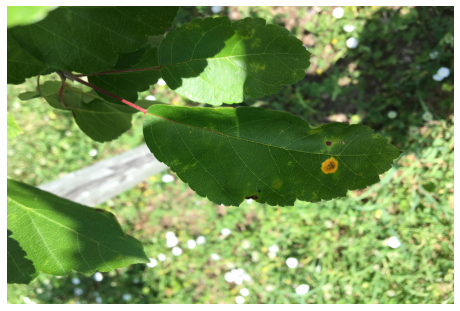

In [ ]:
#źle określone rust
img_path = os.path.join(test_rust_dir, 'Train_1726.jpg')

img = image.load_img(img_path)

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis(False)

(-0.5, 2047.5, 1364.5, -0.5)

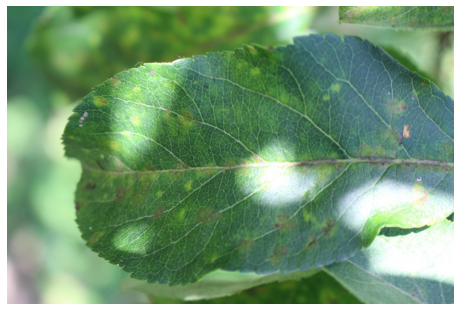

In [ ]:
#źle określone scab
img_path = os.path.join(test_scab_dir, 'Train_1742.jpg')

img = image.load_img(img_path)

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis(False)

**Wnioski:**

W analizie zbudowałam dwa modele: pierwszy wyjściowy oparty o conwolucyje sieci nauronowe z czterema warstwami Conv2D i Max_pool i trenowaniu na 30 epokach. Model okazał się bardzo niestabilny. Na podstawie dokładności na modely treningowym i walidacyjnym zauważalne są duże odchylenia. Również starata na zbiorach treningowych i testowych sugeruje poprawę modelu. 

W celu poprawy modelu decyduję się na wykorzystanie **modelu** **VGG19** **z augumentacją danych**. Dzięki augumentacji ilość parametrów do trenowania diametralnie się zwiększyła (z 1 847 748 do 11 537 668), a model mógł uczyć się rozpoznawania kolejnych cech.Dodatkowo **zwiększeniu uległa ilość epok** z 30 do 50 co znacząco wpłynęło również na wynik dopasowania i straty. Model osiąga dokładność około 87% na zbiorze treningowymi 75% na zbiorze walidacyjnym. 

W celu oceny modelu stosuję metryki dedykowane klasyfikacji. Na podstawie **macierzy pomyłek** można zauważyć, przy których cechach model się mylł. Z kolei już z metryk klasyfikacji wynika, iż najmniejsza pewność i precyzja jest dla kategorii "multiple_diseases".

Tudnością dla mnie w przypadku tego zadania okazało się osobne informacje (w odrębnym pliku) o zbiorze treningowym i testowym. Przydzielenie zdjęć do poszczególnych katalaogów okazało się czasochłonne jednakże wiedząc, że jest to dopiero początek zadania znalazłam rozwiązanie.

Podsumowując, na podstawie tego zadania można stwierdzić, że warto próbować zmieniać parametry i poprawiać model. Wykorzystując technikę augumentacji danych model uległ poprawie jednakże można spróbować zwiększyć jeszcze liczbę epok patrząc na wykresy dokładności i straty.